In [1]:
!git clone https://github.com/misbah4064/face_mask_detection.git
%cd face_mask_detection

Cloning into 'face_mask_detection'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 15 (delta 1), reused 0 (delta 0), pack-reused 12
Unpacking objects: 100% (15/15), done.
/content/face_mask_detection


In [2]:
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
from google.colab.patches import cv2_imshow

In [3]:
def thingspeak_post(valm):
 val= "x"+valm
 URl='https://api.thingspeak.com/update?api_key='
 KEY='A57SXE2FBC4FQL20'
 HEADER='&field1={}'.format(val)
 NEW_URL = URl+KEY+HEADER
 print(NEW_URL)
 data=urllib.request.urlopen(NEW_URL)
 print(data)

In [4]:
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_alt2.xml")
model = load_model("mask_recog.h5")

In [17]:
def face_mask_detector(frame):
  # frame = cv2.imread(fileName)
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  faces = faceCascade.detectMultiScale(gray,
                                        scaleFactor=1.1,
                                        minNeighbors=5,
                                        minSize=(60, 60),
                                        flags=cv2.CASCADE_SCALE_IMAGE)
  faces_list=[]
  preds=[]
  for (x, y, w, h) in faces:
      face_frame = frame[y:y+h,x:x+w]
      face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
      face_frame = cv2.resize(face_frame, (224, 224))
      face_frame = img_to_array(face_frame)
      face_frame = np.expand_dims(face_frame, axis=0)
      face_frame =  preprocess_input(face_frame)
      faces_list.append(face_frame)
      if len(faces_list)>0:
          preds = model.predict(faces_list)
      for pred in preds:
          (mask, withoutMask) = pred
      label = "Mask" if mask > withoutMask else "No Mask"
      color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
      cv2.putText(frame, label, (x, y- 10),
                  cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

      cv2.rectangle(frame, (x, y), (x + w, y + h),color, 3)
  # cv2_imshow(frame)
  return frame

In [18]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

In [19]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


<IPython.core.display.Javascript object>

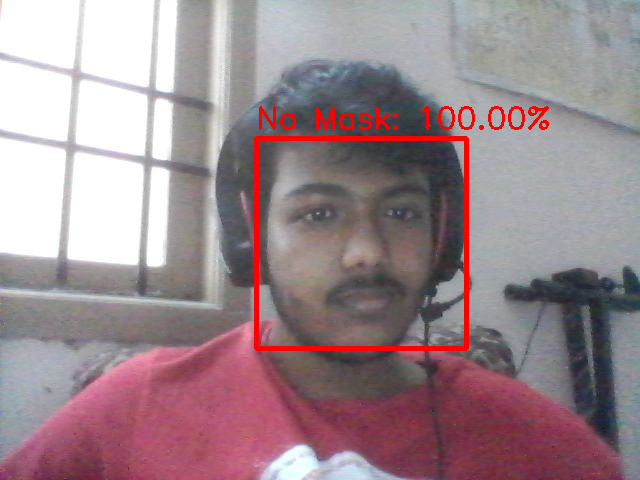

NameError: ignored

In [20]:
input_image = cv2.imread(take_photo())
output = face_mask_detector(input_image)
cv2_imshow(output)
a=label[0]
print(a)
thingspeak_post(a)

In [10]:
import urllib.request
#posting data to thingspeak from python
val = 10 #your data to post it on thingspeak
url = "https://api.thingspeak.com/update?api_key=7G86BRLBZGR4JYYI&field1="+str(val)
#copy this from write a channel feed
response = urllib.request.urlopen(url)
print("Response after posting ",response,"\n")
#reading data from thingspeak and posting to python
url = "https://api.thingspeak.com/channels/1496102/fields/1.json?api_key=A57SXE2FBC4FQL20&results=2" #copy this from read a channel feed
response = urllib.request.urlopen(url)
print("Response after reading ",response.read(),"\n")

Response after posting  <http.client.HTTPResponse object at 0x7f813a4473d0> 

Response after reading  b'{"channel":{"id":1496102,"name":"Mask Detection","description":"IOT Lab 6","latitude":"0.0","longitude":"0.0","field1":"Field Label 1","created_at":"2021-09-03T10:20:42Z","updated_at":"2021-11-12T10:36:00Z","last_entry_id":11},"feeds":[{"created_at":"2021-11-19T09:01:15Z","entry_id":10,"field1":"10"},{"created_at":"2021-11-19T09:07:18Z","entry_id":11,"field1":"10"}]}' 

